# Heart disease or attack prediction
**Task of project: define good enough model to fit on data and predict our target value(heart failure)**

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, learning_curve
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# Data getting and preprocessing

In [2]:
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [4]:
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


**We need to transform our features with float64 dtype to bool(for better oversampling later)**

In [5]:
df.loc[:, ~df.columns.isin(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income'])] = df.loc[:, ~df.columns.isin(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income'])].astype('bool')

In [7]:
df = df.drop_duplicates()

In [8]:
df.describe()

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
count,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000
mean,28.685711,2.601205,3.506425,4.676425,8.085982,4.980388,5.889980
std,6.787118,1.064778,7.714644,9.047423,3.093975,0.992922,2.092546
min,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,24.000000,2.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,27.000000,3.000000,0.000000,0.000000,8.000000,5.000000,6.000000
75%,32.000000,3.000000,2.000000,4.000000,10.000000,6.000000,8.000000
max,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000


In [10]:
stan_dat = StandardScaler().fit_transform(df[['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']])

In [11]:
df.head(10)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,False,True,True,True,40.0,True,False,False,False,False,...,True,False,5.0,18.0,15.0,True,False,9.0,4.0,3.0
1,False,False,False,False,25.0,True,False,False,True,False,...,False,True,3.0,0.0,0.0,False,False,7.0,6.0,1.0
2,False,True,True,True,28.0,False,False,False,False,True,...,True,True,5.0,30.0,30.0,True,False,9.0,4.0,8.0
3,False,True,False,True,27.0,False,False,False,True,True,...,True,False,2.0,0.0,0.0,False,False,11.0,3.0,6.0
4,False,True,True,True,24.0,False,False,False,True,True,...,True,False,2.0,3.0,0.0,False,False,11.0,5.0,4.0
5,False,True,True,True,25.0,True,False,False,True,True,...,True,False,2.0,0.0,2.0,False,True,10.0,6.0,8.0
6,False,True,False,True,30.0,True,False,False,False,False,...,True,False,3.0,0.0,14.0,False,False,9.0,6.0,7.0
7,False,True,True,True,25.0,True,False,False,True,False,...,True,False,3.0,0.0,0.0,True,False,11.0,4.0,4.0
8,True,True,True,True,30.0,True,False,True,False,True,...,True,False,5.0,30.0,30.0,True,False,9.0,5.0,1.0
9,False,False,False,True,24.0,False,False,False,False,False,...,True,False,2.0,0.0,0.0,False,True,8.0,4.0,3.0


<AxesSubplot:>

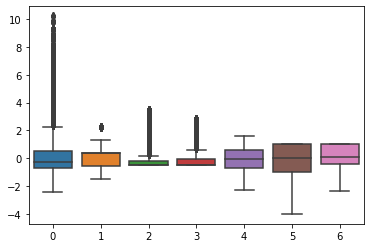

In [12]:
sns.boxplot(data=stan_dat)

Outliers in `BMI`, `GenHlth`, `MentHlth`, `PhysHlth`

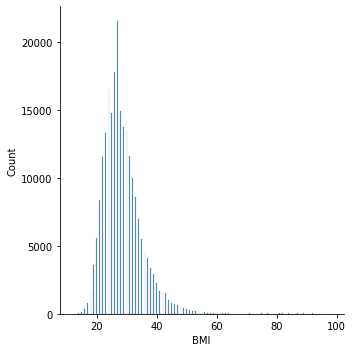

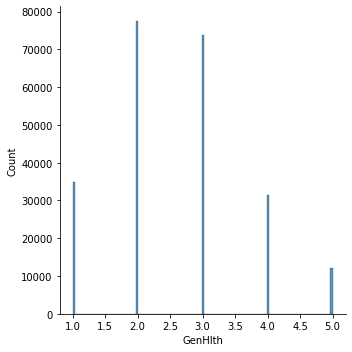

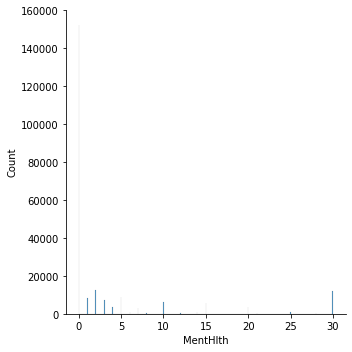

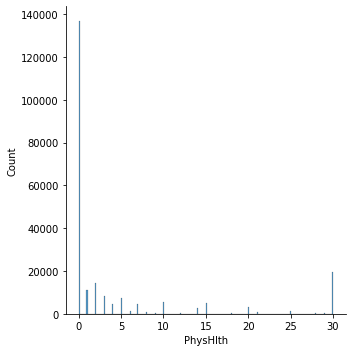

In [13]:
for i in ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth']:
    sns.displot(df[i])

In [14]:
print('BMI outliers')
df[df['BMI']>df['BMI'].quantile(0.75)+1.5*(df['BMI'].quantile(0.75)-df['BMI'].quantile(0.25))].count()['BMI']

BMI outliers


5638

In [15]:
print('MentHlth outliers')
df[df['MentHlth']>df['MentHlth'].quantile(0.75)+1.5*(df['MentHlth'].quantile(0.75)-df['MentHlth'].quantile(0.25))].count()['BMI']

MentHlth outliers


36163

In [16]:
print('PhysHlth outliers')
df[df['PhysHlth']>df['PhysHlth'].quantile(0.75)+1.5*(df['PhysHlth'].quantile(0.75)-df['PhysHlth'].quantile(0.25))].count()['BMI']

PhysHlth outliers


34346

In [17]:
df = df.drop(df[df['BMI']>df['BMI'].quantile(0.75)+1.5*(df['BMI'].quantile(0.75)-df['BMI'].quantile(0.25))].index)

c:\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BMI'>

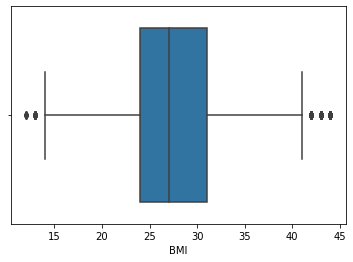

In [19]:
sns.boxplot(df['BMI'])

### Correlation matrix

In [20]:
df.corr().style.background_gradient()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
HeartDiseaseorAttack,1.000000,0.202062,0.176358,0.050473,0.046694,0.105949,0.199040,0.166995,-0.072006,-0.006970,-0.027054,-0.035517,0.026623,0.020706,0.246957,0.051141,0.169172,0.203160,0.090911,0.224959,-0.081886,-0.121779
HighBP,0.202062,1.000000,0.284938,0.110521,0.211508,0.075930,0.125143,0.255445,-0.099548,-0.017561,-0.041865,-0.012563,0.052722,0.000203,0.267843,0.033085,0.138998,0.204609,0.049669,0.344267,-0.111103,-0.136011
HighChol,0.176358,0.284938,1.000000,0.095202,0.109059,0.074596,0.089436,0.201345,-0.061520,-0.025891,-0.026585,-0.018772,0.053544,0.001828,0.187238,0.048426,0.108584,0.134003,0.023665,0.265441,-0.048749,-0.060012
CholCheck,0.050473,0.110521,0.095202,1.000000,0.046173,-0.003631,0.028106,0.075064,-0.003634,0.018391,-0.000448,-0.020875,0.115723,-0.054927,0.062693,-0.002655,0.039808,0.047821,-0.023864,0.096836,-0.009656,0.002845
BMI,0.046694,0.211508,0.109059,0.046173,1.000000,-0.003095,0.011516,0.218020,-0.116223,-0.068118,-0.045232,-0.059706,-0.001742,0.037662,0.199072,0.047741,0.077895,0.154559,0.063967,-0.025932,-0.077573,-0.045892
Smoker,0.105949,0.075930,0.074596,-0.003631,-0.003095,1.000000,0.054406,0.047329,-0.068430,-0.062586,-0.014807,0.096195,-0.014507,0.038312,0.137209,0.077562,0.101162,0.110112,0.096929,0.108074,-0.136640,-0.096500
Stroke,0.199040,0.125143,0.089436,0.028106,0.011516,0.054406,1.000000,0.097740,-0.059098,-0.004492,-0.032688,-0.021224,0.013933,0.027963,0.170654,0.061293,0.140447,0.170430,0.004362,0.128525,-0.063906,-0.116654
Diabetes,0.166995,0.255445,0.201345,0.075064,0.218020,0.047329,0.097740,1.000000,-0.095498,-0.023172,-0.042336,-0.064913,0.024652,0.023382,0.274787,0.052147,0.149647,0.196589,0.035422,0.188899,-0.106288,-0.142154
PhysActivity,-0.072006,-0.099548,-0.061520,-0.003634,-0.116223,-0.068430,-0.059098,-0.095498,1.000000,0.123654,0.134195,0.022035,0.023942,-0.044479,-0.231201,-0.101249,-0.193094,-0.227548,0.029961,-0.089218,0.170939,0.162798
Fruits,-0.006970,-0.017561,-0.025891,0.018391,-0.068118,-0.062586,-0.004492,-0.023172,0.123654,1.000000,0.242481,-0.028692,0.022083,-0.031351,-0.069235,-0.050247,-0.023042,-0.027223,-0.090109,0.072765,0.084132,0.049143


Columns MentHlth and PhysHlth have a lot of outliers and have really low correlation with target, then we can drop them

In [21]:
for i in ['MentHlth', 'PhysHlth']:
    del df[i]

Let's check distribution of target

<AxesSubplot:>

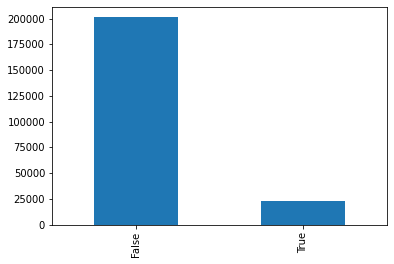

In [22]:
df.HeartDiseaseorAttack.value_counts().plot(kind = 'bar')

Imbalanced data can affect on models' work

**Data splitting**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, 0], test_size = 0.2, random_state = 50)

In [24]:
print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", y_train.shape)
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

X_train dataset:  (179259, 19)
y_train dataset:  (179259,)
X_test dataset:  (44815, 19)
y_test dataset:  (44815,)


In [25]:
y_train.value_counts()

False    160853
True      18406
Name: HeartDiseaseorAttack, dtype: int64

**Logistic Regression on imbalanced data to understand how imbalance will affect**

In [26]:
logit = LogisticRegression()
logit.fit(X_train, y_train.ravel())
predictions = logit.predict(X_test)

print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     40198
        True       0.54      0.11      0.19      4617

    accuracy                           0.90     44815
   macro avg       0.72      0.55      0.57     44815
weighted avg       0.87      0.90      0.87     44815



c:\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Recall and f1-score for `True` class are really low.
That means regression can't notice `True` class

In [27]:
confusion_matrix(y_test, predictions)

array([[39745,   453],
       [ 4087,   530]], dtype=int64)

**Oversampling to fix imbalance**

In [28]:
sm = SMOTE(random_state=50)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [29]:
print("X_train dataset: ", X_train_res.shape)
print("y_train dataset: ", y_train_res.shape)
pd.DataFrame(y_train_res).value_counts()

X_train dataset:  (321706, 19)
y_train dataset:  (321706,)


False    160853
True     160853
dtype: int64

Now we can test models on our data

In [30]:
def val_curve(est, X = X_train_res, y = y_train_res, cv = 5):
    #function for plotting curve where we can compare training scores and validation score and define, is there under or over -fitting
     train_sizes, train_scores, test_scores = learning_curve(est, X_train_res, y_train_res, cv=5)

     train_mean = np.mean(train_scores, axis=1)
     test_mean = np.mean(test_scores, axis=1)
     print('train size', train_sizes, '\ntrain score', train_scores, '\nval score', test_scores)
     plt.plot(train_sizes, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training Accuracy')
     plt.plot(train_sizes, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation Accuracy')
     plt.xlabel('train size')
     plt.ylabel('Accuracy')
     plt.legend()
     plt.grid()
     plt.show()

# Model testing and selection

### Logistic Regression

Count of max iteration is 500, because dataset is large and not standartized

In [31]:
logit1 = LogisticRegression(max_iter=500)
cross_val_score(logit1, X_train_res, y_train_res)

array([0.7676168 , 0.82229061, 0.82392254, 0.81901121, 0.82255483])

In [32]:
print(classification_report(y_train_res, cross_val_predict(logit1, X_train_res, y_train_res)))

              precision    recall  f1-score   support

       False       0.82      0.79      0.81    160853
        True       0.80      0.83      0.81    160853

    accuracy                           0.81    321706
   macro avg       0.81      0.81      0.81    321706
weighted avg       0.81      0.81      0.81    321706



train size [ 25736  83643 141550 199457 257364] 
train score [[       nan 0.90181069 0.90181069 0.90181069 0.90181069]
 [       nan 0.86644429 0.86637256 0.89907105 0.89907105]
 [0.91939951 0.87956906 0.87950548 0.87962557 0.89903214]
 [0.82468903 0.80491535 0.8049003  0.80658989 0.80551698]
 [0.82252763 0.81008999 0.80933231 0.81080882 0.80970921]] 
val score [[       nan 0.59602742 0.59500163 0.59437994 0.59660248]
 [       nan 0.64043145 0.63755615 0.58991934 0.59234392]
 [0.59034534 0.62052191 0.61890552 0.61962046 0.59046331]
 [0.74040285 0.80600239 0.80792962 0.80356227 0.80609565]
 [0.7676168  0.82235278 0.82396916 0.81896458 0.82246157]]


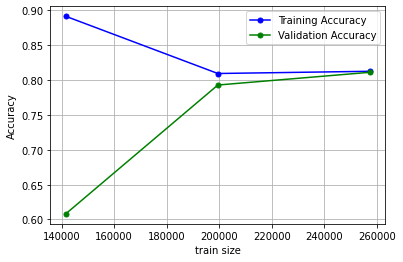

In [33]:
val_curve(logit1)

### Decision Tree Classification

In [34]:
tree = DecisionTreeClassifier()
cross_val_score(tree, X_train_res, y_train_res)

array([0.80889621, 0.91745543, 0.91944483, 0.91554374, 0.91876098])

In [35]:
print(classification_report(y_train_res, cross_val_predict(tree, X_train_res, y_train_res)))

              precision    recall  f1-score   support

       False       0.91      0.88      0.89    160853
        True       0.89      0.91      0.90    160853

    accuracy                           0.90    321706
   macro avg       0.90      0.90      0.90    321706
weighted avg       0.90      0.90      0.90    321706



train size [ 25736  83643 141550 199457 257364] 
train score [[1.         0.99801834 0.99801834 0.99801834 0.99801834]
 [1.         0.99355595 0.99347226 0.99524168 0.99524168]
 [0.99866478 0.99141646 0.99130343 0.99158601 0.99281526]
 [0.99682137 0.99221887 0.99219882 0.99240939 0.99229909]
 [0.99701979 0.99361993 0.99358885 0.99372873 0.9936005 ]] 
val score [[0.5        0.64915062 0.64950809 0.648187   0.65086026]
 [0.5        0.7413158  0.74515472 0.70135683 0.70443419]
 [0.69208293 0.77773115 0.78292224 0.78149236 0.7516669 ]
 [0.78511703 0.90247276 0.90505277 0.90085637 0.90472638]
 [0.80923813 0.91705134 0.91960025 0.91587013 0.91947592]]


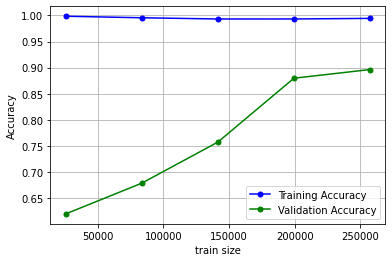

In [36]:
val_curve(tree)

By curve, tree classifier is overfitting

### SGD for classification

In [37]:
sc = SGDClassifier(loss = 'hinge', alpha = 0.1)
cross_val_score(sc, X_train_res, y_train_res)

array([0.77111374, 0.79499852, 0.79403491, 0.79089539, 0.78996285])

In [38]:
print(classification_report(y_train_res, cross_val_predict(sc, X_train_res, y_train_res)))

              precision    recall  f1-score   support

       False       0.83      0.74      0.78    160853
        True       0.76      0.85      0.80    160853

    accuracy                           0.79    321706
   macro avg       0.80      0.79      0.79    321706
weighted avg       0.80      0.79      0.79    321706



As SGD classifier also linear model as logistic regression has similar curve

train size [ 25736  83643 141550 199457 257364] 
train score [[       nan 0.89881878 0.89881878 0.89881878 0.89881878]
 [       nan 0.85707112 0.85707112 0.89705056 0.89705056]
 [0.90909219 0.87397386 0.87397386 0.87397386 0.8969834 ]
 [0.80104985 0.78321643 0.77818277 0.78653544 0.78334177]
 [0.80412567 0.78637261 0.79225921 0.79412816 0.79179295]] 
val score [[       nan 0.50000777 0.50000777 0.49999223 0.49999223]
 [       nan 0.50000777 0.50000777 0.49999223 0.49999223]
 [0.5        0.50000777 0.50000777 0.49999223 0.49999223]
 [0.7329738  0.76826596 0.75165136 0.76703812 0.75808582]
 [0.77335178 0.79369298 0.79861985 0.79663045 0.80146407]]


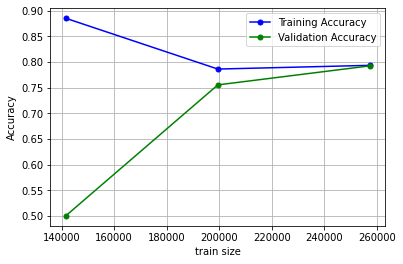

In [39]:
val_curve(sc)

### Naive Bayes' probability prediction

In [40]:
nb = GaussianNB()
cross_val_score(nb, X_train_res, y_train_res)

array([0.74867116, 0.78139911, 0.78240935, 0.77970501, 0.78436767])

In [41]:
print(classification_report(y_train_res, cross_val_predict(nb, X_train_res, y_train_res)))

              precision    recall  f1-score   support

       False       0.85      0.67      0.75    160853
        True       0.73      0.88      0.80    160853

    accuracy                           0.78    321706
   macro avg       0.79      0.78      0.77    321706
weighted avg       0.79      0.78      0.77    321706



train size [ 25736  83643 141550 199457 257364] 
train score [[1.         0.81710445 0.81710445 0.81710445 0.81710445]
 [1.         0.79492605 0.79454348 0.8149636  0.8149636 ]
 [0.77499823 0.80195691 0.80190039 0.80320735 0.81646768]
 [0.75250305 0.75914608 0.75913104 0.76034433 0.75923131]
 [0.77644892 0.774681   0.77487916 0.7754853  0.77479368]] 
val score [[0.5        0.73666869 0.73882905 0.73531652 0.73889122]
 [0.5        0.73921761 0.74184424 0.73348254 0.73632676]
 [0.75512107 0.73781881 0.74019676 0.73671531 0.734757  ]
 [0.75395543 0.78517586 0.78753827 0.78329525 0.78839309]
 [0.74867116 0.78139911 0.78242489 0.77970501 0.78436767]]


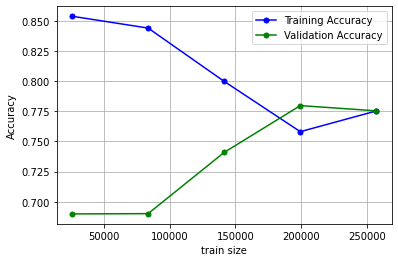

In [42]:
val_curve(nb)

Strange result on 200 000 sample size data

**Best results shown by linear models(*Logistic Regression and SGD*), so let's fine-tune this models and also tree classifier**

# Fine-tuning and predicting(testing)

### Logistic Regression fine-tuning

In [50]:
logit_ft = GridSearchCV(LogisticRegression(max_iter = 500), param_grid={
    'C':[0.01, 0.1, 0.5, 0.8, 1.0],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'saga']
}, scoring = 'accuracy')

In [52]:
logit_ft.fit(X_train_res, y_train_res)

c:\Python\Python39\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\Python\Python39\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


GridSearchCV(estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.01, 0.1, 0.5, 0.8, 1.0],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

In [53]:
print(logit_ft.best_params_)
print(logit_ft.best_score_)

{'C': 0.5, 'solver': 'lbfgs'}
0.8111289295781867


In [55]:
logit_best = logit_ft.best_estimator_
print(classification_report(y_train_res, cross_val_predict(logit_best, X_train_res, y_train_res)))

              precision    recall  f1-score   support

       False       0.82      0.79      0.81    160853
        True       0.80      0.83      0.81    160853

    accuracy                           0.81    321706
   macro avg       0.81      0.81      0.81    321706
weighted avg       0.81      0.81      0.81    321706



In [62]:
logit_best.fit(X_train_res, y_train_res)
y_pred_logit = logit_best.predict(X_test)
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

       False       0.96      0.79      0.87     40198
        True       0.28      0.68      0.39      4617

    accuracy                           0.78     44815
   macro avg       0.62      0.74      0.63     44815
weighted avg       0.89      0.78      0.82     44815



In [63]:
confusion_matrix(y_test, y_pred_logit)

array([[31889,  8309],
       [ 1463,  3154]], dtype=int64)

### SGD fine-tuning

In [56]:
sgd_ft = GridSearchCV(SGDClassifier(), param_grid={
    'loss':['hinge', 'log', 'squared_error'],
    'alpha':[1.0, 0.1, 0.01, 0.001]
}, scoring = 'accuracy')

In [57]:
sgd_ft.fit(X_train_res, y_train_res)

c:\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:69

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'alpha': [1.0, 0.1, 0.01, 0.001],
                         'loss': ['hinge', 'log', 'squared_error']},
             scoring='accuracy')

In [58]:
print(sgd_ft.best_params_)
print(sgd_ft.best_score_)

{'alpha': 0.01, 'loss': 'hinge'}
0.80830956069466


In [59]:
sgd_best = sgd_ft.best_estimator_
print(classification_report(y_train_res, cross_val_predict(sgd_best, X_train_res, y_train_res)))

              precision    recall  f1-score   support

       False       0.85      0.75      0.80    160853
        True       0.78      0.86      0.82    160853

    accuracy                           0.81    321706
   macro avg       0.81      0.81      0.81    321706
weighted avg       0.81      0.81      0.81    321706



In [64]:
sgd_best.fit(X_train_res, y_train_res)
y_pred_sgd = sgd_best.predict(X_test)
print(classification_report(y_test, y_pred_sgd))

              precision    recall  f1-score   support

       False       0.96      0.79      0.86     40198
        True       0.27      0.70      0.39      4617

    accuracy                           0.78     44815
   macro avg       0.61      0.74      0.63     44815
weighted avg       0.89      0.78      0.81     44815



In [65]:
confusion_matrix(y_test, y_pred_sgd)

array([[31563,  8635],
       [ 1394,  3223]], dtype=int64)

### Desicion tree fine-tuning

In [66]:
tree_ft = GridSearchCV(DecisionTreeClassifier(),param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}, scoring = 'roc_auc', n_jobs=-1, cv = 3)

In [67]:
tree_ft.fit(X_train_res, y_train_res)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 7, 10]},
             scoring='roc_auc')

In [70]:
print(tree_ft.best_params_)
print(tree_ft.best_score_)

{'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.9348209878582986


In [71]:
tree_best = tree_ft.best_estimator_
print(classification_report(y_train_res, cross_val_predict(tree_best, X_train_res, y_train_res)))

              precision    recall  f1-score   support

       False       0.89      0.87      0.88    160853
        True       0.87      0.89      0.88    160853

    accuracy                           0.88    321706
   macro avg       0.88      0.88      0.88    321706
weighted avg       0.88      0.88      0.88    321706



In [73]:
tree_best.fit(X_train_res, y_train_res)
y_pred_tree = tree_best.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

       False       0.93      0.88      0.90     40198
        True       0.28      0.42      0.34      4617

    accuracy                           0.83     44815
   macro avg       0.60      0.65      0.62     44815
weighted avg       0.86      0.83      0.84     44815



train size [ 25736  83643 141550 199457 257364] 
train score [[1.         0.92640659 0.9264843  0.92617345 0.92632888]
 [1.         0.90249035 0.90343484 0.92322131 0.92328109]
 [0.96544684 0.90916284 0.90789827 0.90879548 0.92204875]
 [0.93453727 0.90514748 0.90333255 0.90598976 0.90407958]
 [0.93790118 0.91579242 0.91650736 0.91656953 0.91701637]] 
val score [[0.5        0.62120576 0.6182372  0.61327925 0.61941841]
 [0.5        0.68175813 0.68541055 0.63409024 0.63457205]
 [0.65569923 0.68287717 0.67732861 0.67787259 0.65527424]
 [0.76530105 0.88730359 0.88742792 0.88408635 0.88773877]
 [0.79271704 0.90292349 0.90122939 0.89863384 0.90317216]]


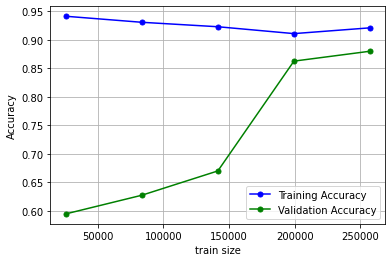

In [74]:
val_curve(tree_best)

In [75]:
confusion_matrix(y_test, y_pred_tree)

array([[35185,  5013],
       [ 2679,  1938]], dtype=int64)

##### By the results of fine-tununig and testing several models (Logit, SGD, tree):
##### SGD classifier is good enough model for this situation, because Type-II error is most valuable in this case(need to minimize) (Logit - 1463, SGD - 1394, tree - 2679) 